In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_gps = pd.read_csv("data/dataset_1_key_with_population.csv")
data_pop = pd.read_csv("data/dataset_1_wp.csv.zip")

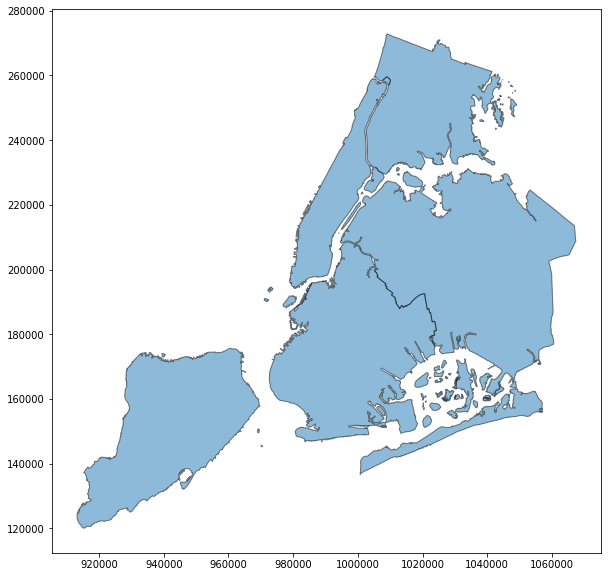

In [250]:
import geopandas
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

bin size = 40, dims = (41, 41)


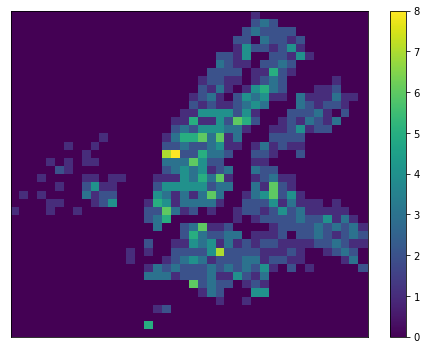

In [273]:
# filter outliers
data_gps = data_gps[(data_gps["station_latitude"] > 30) & (data_gps["station_latitude"] < 45)]

y = np.asarray(data_gps["station_latitude"])
x = np.asarray(data_gps["station_longitude"])
station_id = list(data_gps["station_id"])
stations = len(station_id)

start = list(data_pop["start_station_id"])
end = list(data_pop["end_station_id"])
trips = len(start)

#bins = 40
#bin_ids = bins*bins
districts = bins*bins

left_x = -74.09
right_x = -73.9
bottom_y = 40.64
top_y = 40.82

bin_x = np.linspace(left_x, right_x, bins+1)
bin_y = np.linspace(bottom_y, top_y, bins+1)

#width = right_x - left_x
#height = top_y - bottom_y

# zipping or binning
group_x = np.digitize(x, bin_x)-1
group_y = np.digitize(y, bin_y)-1
index = group_x + bins*group_y
# compute the bin index by group_x + bins*group_y

# plot
plt.figure(figsize=(8, 6))
bins = 40
hist, xedges, yedges, _ = plt.hist2d(x, y, bins=bins, range=[[left_x, right_x], [bottom_y, top_y]])
plt.colorbar()
plt.xticks([])
plt.yticks([])
print("bin size = {}, dims = ({}, {})".format(bins,len(xedges), len(yedges)))
plt.show()

In [259]:
# convert to order of station_id
start_ = []
end_ = []
for k in range(trips):
    start_.append(station_id.index(start[k]))
    end_.append(station_id.index(end[k]))
print('Processed remapping of coordinates')
    
# get trip times
start_time = data_pop["starttime"]
end_time = data_pop["stoptime"]
conversion_factor = 1 / 10**9 / 86400
s_time = np.asarray(pd.to_datetime(start_time).astype(int)) * conversion_factor # in days
#e_time = np.asarray(pd.to_datetime(end_time).astype(int)) * conversion_factor # in days
#print('Longest ride in dataset is {0:.2f} days'.format((e_time - s_time).max())) # check duration longest ride

# bin data into days
min_time = s_time.min()
max_time = s_time.max()
delta_time = int(np.ceil(max_time - min_time))
s_time = s_time - min_time

# save basic data
np.save('processed/loc_data', (x, y, index, delta_time, districts))

# compute spatially binned T and save transitions
T = np.zeros((districts, districts))
for t in range(delta_time):
    idx = np.where((s_time>=t)*(s_time<t+1))[0]
    for ids in idx:
        T[index[end_[ids]], index[start_[ids]]] += 1
    a = np.where(T > 0)
    i = a[0]
    j = a[1]
    #np.save('processed/T_{}'.format(t), (i,j,T[i[:],j[:]]))
    np.save('processed/T_full_{}'.format(t), T)
    print('Processed day {}'.format(t))

Processed remapping of coordinates
Processed day 0
Processed day 1
Processed day 2
Processed day 3
Processed day 4
Processed day 5
Processed day 6
Processed day 7
Processed day 8
Processed day 9
Processed day 10
Processed day 11
Processed day 12
Processed day 13
Processed day 14
Processed day 15
Processed day 16
Processed day 17
Processed day 18
Processed day 19
Processed day 20
Processed day 21
Processed day 22
Processed day 23
Processed day 24
Processed day 25
Processed day 26


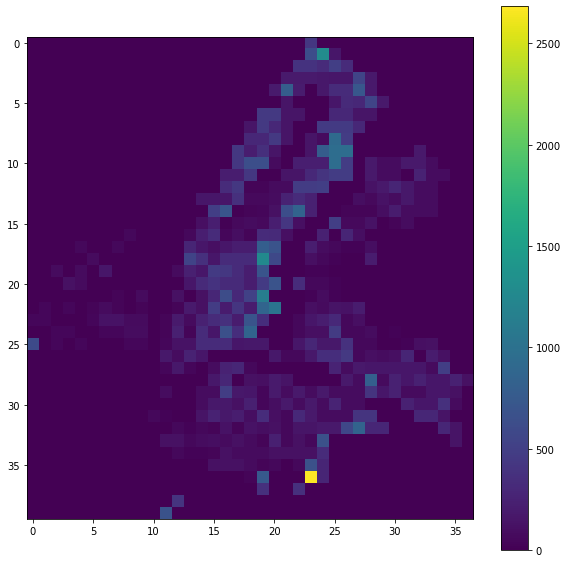

In [248]:
# load population density data
data_gps.groupby(["binIndexLat", "binIndexLong"]).count()["density"][(40.663714433, -73.9590171425)]
binPopMap = data_gps.groupby(["binIndexLat", "binIndexLong"]).sum()["density"].unstack(fill_value=0)
binPopMap = binPopMap.sort_index(ascending=False)
plt.figure(figsize=(10, 10))
plt.imshow(binPopMap.values)
plt.colorbar()

# Get R_0 grid
R_0 = 2.6

<ErrorbarContainer object of 3 artists>

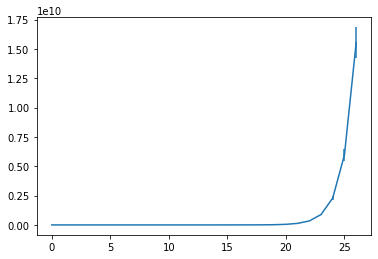

In [281]:
# perform uncertainty analysis of the spread
K_m = np.load('K_m_R=2.6_1.npy')
K_sd = np.load('K_sd_R=2.6_1.npy')

t = range(delta_time)
plt.errorbar(t, y=K_m[19, 20, :], yerr=K_sd[19, 19, :], )

40